In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('praha_listings.csv.gz', compression='gzip')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10593 entries, 0 to 10592
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            10593 non-null  int64  
 1   listing_url                                   10593 non-null  object 
 2   scrape_id                                     10593 non-null  int64  
 3   last_scraped                                  10593 non-null  object 
 4   source                                        10593 non-null  object 
 5   name                                          10593 non-null  object 
 6   description                                   10361 non-null  object 
 7   neighborhood_overview                         4585 non-null   object 
 8   picture_url                                   10592 non-null  object 
 9   host_id                                       10593 non-null 

In [10]:
columns = ['latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price']
f_columns = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'price']
# df_hotel['price'] = df_need['price'].replace('[\$,]', '', regex=True).astype(float)
#
df['price'] = df['price'].replace('[$,]', '', regex=True).astype(float)
df_need = df[columns]
df_numeric = df[f_columns]

In [7]:
df_need.describe()

,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price
count,10593.000000,10593.000000,10593.000000,9511.000000,10363.00000,9496.000000,9.403000e+03
mean,50.081138,14.430494,4.031719,1.263800,1.39062,2.502633,4.385323e+03
std,0.016747,0.031890,2.550608,0.675789,0.98663,2.197560,2.210931e+04
min,49.947830,14.271417,1.000000,0.000000,0.00000,0.000000,2.280000e+02
25%,50.075150,14.418230,2.000000,1.000000,1.00000,1.000000,1.557500e+03
50%,50.081770,14.428880,4.000000,1.000000,1.00000,2.000000,2.233000e+03
75%,50.089380,14.444010,5.000000,1.500000,2.00000,3.000000,3.350000e+03
max,50.170570,14.684160,16.000000,15.000000,34.00000,32.000000,1.232764e+06


In [8]:
df_piece = df_need[df_need['room_type']=='Entire home/apt']

In [20]:
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9377 entries, 2 to 10592
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   accommodates  9377 non-null   int64  
 1   bathrooms     9377 non-null   float64
 2   bedrooms      9377 non-null   float64
 3   beds          9377 non-null   float64
 4   price         9377 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 439.5 KB


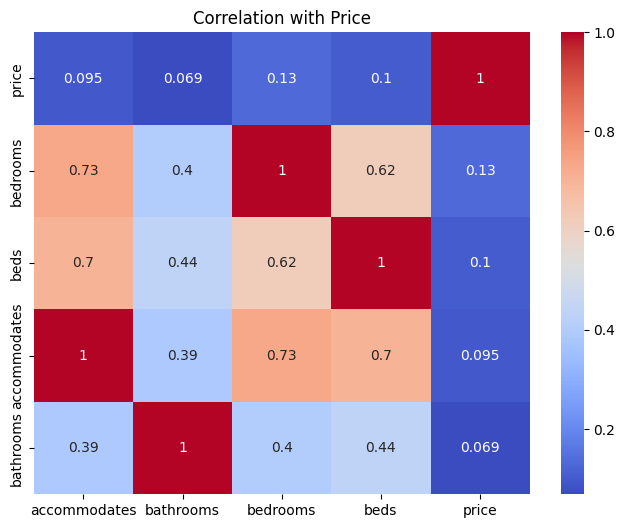

In [ ]:
# df_numeric=df_piece[f_columns]
df_numeric = df_numeric.dropna()

# 상관계수 계산
corr = df_numeric.corr()

# heatmap 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(corr.sort_values(by='price', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlation with Price')
plt.show()

C:\Users\tower\AppData\Local\Temp\ipykernel_27052\2715902762.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_geo.groupby(['lat_bin', 'lon_bin'])['price']


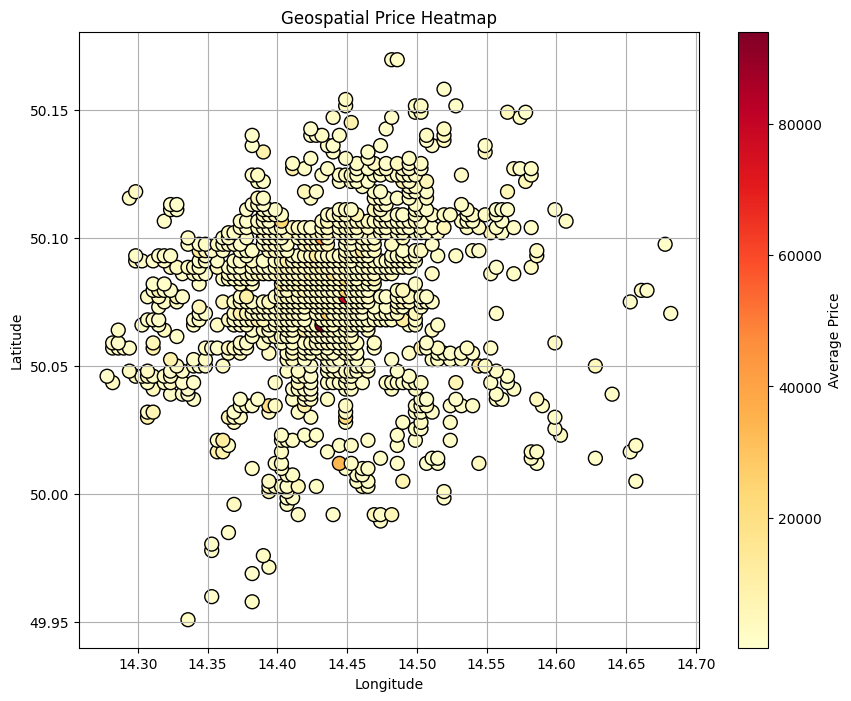

In [21]:
# 결측치 제거 (위도/경도/가격)
df_geo = df_need[['latitude', 'longitude', 'price']].dropna()

# ▶️ 위도/경도 범위를 적절한 bin 단위로 자름 (예: 100m ~ 500m 간격 정도)
lat_bins = np.linspace(df_geo['latitude'].min(), df_geo['latitude'].max(), 100)
lon_bins = np.linspace(df_geo['longitude'].min(), df_geo['longitude'].max(), 100)

# ▶️ 각 위도/경도를 bin에 매핑
df_geo['lat_bin'] = pd.cut(df_geo['latitude'], bins=lat_bins)
df_geo['lon_bin'] = pd.cut(df_geo['longitude'], bins=lon_bins)

# ▶️ 각 구간마다 평균 가격 계산
heatmap_data = (
    df_geo.groupby(['lat_bin', 'lon_bin'])['price']
    .mean()
    .reset_index()
)

# ▶️ bin의 중앙값을 추출해서 좌표로 사용
heatmap_data['lat_center'] = heatmap_data['lat_bin'].apply(lambda x: x.mid)
heatmap_data['lon_center'] = heatmap_data['lon_bin'].apply(lambda x: x.mid)

# ▶️ 시각화 (Scatter 형태의 Heatmap)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    heatmap_data['lon_center'],
    heatmap_data['lat_center'],
    c=heatmap_data['price'],
    cmap='YlOrRd',
    s=100,
    edgecolors='black'
)
plt.colorbar(scatter, label='Average Price')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# plt.xlim(14.4, 14.5)
# plt.ylim(50, 50.1)
plt.title('Geospatial Price Heatmap')
plt.grid(True)
plt.show()